In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.applications.vgg16 import  VGG16
import os
import seaborn as sns
from sklearn import preprocessing

#XGBOOST
import xgboost as xgb
model = xgb.XGBClassifier()

In [2]:
print(os.listdir("./dataset/"))

['test', 'train2', 'valid2']


In [3]:
SIZE = 256 # Resized Image

In [4]:
train_images = []
train_labels = []

- Using directory_path.split("\\")\
- Ouput:\
['./dataset/train2', 'cats']\
['./dataset/train2', 'dogs']
- glob return ./dataset/train2\cats

In [5]:
for directory_path in glob.glob("./dataset/train2/*"):
    label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR) # cv2.imread_color is default of cv2.imread() function
        if img is not None:
            img = cv2.resize(img, (SIZE, SIZE))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            train_images.append(img)
            train_labels.append(label)

# Convert lists to arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [7]:

# Captures test/validation data and labels into respective lists
test_images = []
test_labels = []
for directory_path in glob.glob("./dataset/valid2/*"):
    animal_labels = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is not None:
            img = cv2.resize(img, (SIZE, SIZE))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            test_images.append(img)
            test_labels.append(animal_labels)
# Convert lists to arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)


        

In [8]:
# Encode labels from text to integers.
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

### x_train refer to data train of image
### y_train refer to data train of labels

In [9]:
# Split data into test and train datasets (already split but assigning to meaning)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

#One hot encode y values for neural network. 
# from keras.utils import to_categorical
# y_train_one_hot = to_categorical(y_train)
# y_test_one_hot = to_categorical(y_test)

In [10]:

#Load model wothout classifier/fully connected layers
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0


#Now, let us use features from convolutional network for RF
feature_extractor=VGG_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_training = features #This is our X input to RF




Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

11/11 [==============================] - 90s 8s/step
Accuracy =  0.8771929824561403
1/1 [==============================] - 0s 280ms/step
The prediction for this image is:  ['dogs']
The actual label for this image is:  dogs


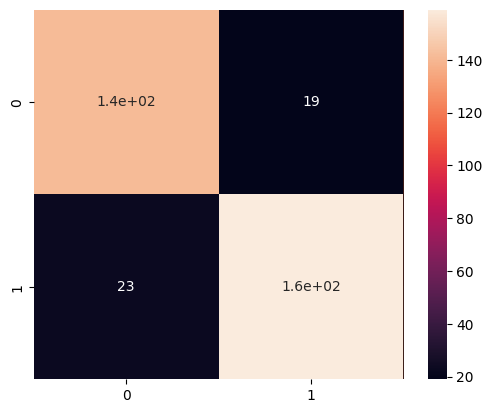

In [11]:

# Train the model on training data with xgboosting
model.fit(X_for_training, y_train) #For sklearn no one hot encoding

#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

#Now predict using the trained RF model. 
prediction = model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction = le.inverse_transform(prediction)

#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction))

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, prediction)
#print(cm)
sns.heatmap(cm, annot=True)

#Check results on a few select images
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=VGG_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction = model.predict(input_img_features)[0] 
prediction = le.inverse_transform([prediction])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction)
print("The actual label for this image is: ", test_labels[n])

In [12]:
import pickle

# Save the trained model to a file
model_filename = './Model/XG_boosting.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)

In [13]:
import pickle

# Load the XGBoost model
with open("./Model/XG_boosting.pkl", "rb") as f:
    loaded_model = pickle.load(f)

# Make predictions using the loaded model
prediction = loaded_model.predict(X_test_features)

1/1 [==============================] - 0s 306ms/step


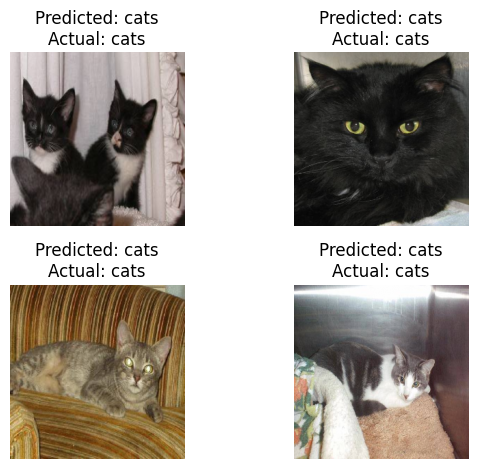

In [14]:
fig, axes = plt.subplots(2, 2)  # Create a 2x2 subplot grid
for i, ax in enumerate(axes.flat):  # Iterate through each subplot
    ax.imshow(x_test[i])  # Display the image
    input_img = np.expand_dims(x_test[i], axis=0)
    input_img_feature = VGG_model.predict(input_img)
    input_img_features = input_img_feature.reshape(input_img_feature.shape[0], -1)
    prediction = loaded_model.predict(input_img_features)[0]
    prediction = le.inverse_transform([prediction])[0]
    actual_label = test_labels[i]
    ax.set_title(f"Predicted: {prediction}\nActual: {actual_label}")
    ax.axis('off')
plt.tight_layout()
plt.show()